In [1]:
from sklearn.datasets import make_blobs
import numpy as np
from keras.models import Sequential, Model
from keras_uncertainty.layers import StochasticDropout, SamplingSoftmax
from keras_uncertainty.models import DisentangledStochasticClassifier, StochasticClassifier
from keras.layers import Dense, Input, Dropout
from keras_uncertainty.utils import numpy_entropy


Keras Uncertainty will use standalone Keras backend

In [2]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
BATCH_SIZE = 256
NUM_SAMPLES = 100

In [3]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)


def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(2,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model


def train_stochastic_model(trunk_model, x_train, y_train, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE)

    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)

    return fin_model

def eval_disentangled_model(disentangled_model, samples):
    pred_mean, pred_ale_std, pred_epi_std = disentangled_model.predict(samples, batch_size=BATCH_SIZE)
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return ale_entropy, epi_entropy

def train_disentangling_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    return train_stochastic_model(model, x_train, y_train, epochs=50)

In [4]:
disentangled_dropout_model = train_disentangling_dropout_model(X, y)

Epoch 1/50


/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/__autograph_generated_filemh5enuy_.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'linear_variance', if_body, else_body, get_state, set_state, ('do_return', 'retval_'), 2)
/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/__autograph_generated_filemh5enuy_.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'logit', if_body_1, else_body_1, get_state_1, set_state_1, ('do_return', 'retval_'), 2)


4/4 - 0s - loss: 0.7202 - accuracy: 0.5610 - 292ms/epoch - 73ms/step
Epoch 2/50
4/4 - 0s - loss: 0.6686 - accuracy: 0.6250 - 10ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.6328 - accuracy: 0.6430 - 10ms/epoch - 3ms/step
Epoch 4/50
4/4 - 0s - loss: 0.5893 - accuracy: 0.6800 - 10ms/epoch - 3ms/step
Epoch 5/50
4/4 - 0s - loss: 0.5283 - accuracy: 0.7450 - 10ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.4766 - accuracy: 0.7890 - 10ms/epoch - 3ms/step
Epoch 7/50
4/4 - 0s - loss: 0.4503 - accuracy: 0.8230 - 11ms/epoch - 3ms/step
Epoch 8/50
4/4 - 0s - loss: 0.4207 - accuracy: 0.8300 - 10ms/epoch - 2ms/step
Epoch 9/50
4/4 - 0s - loss: 0.3966 - accuracy: 0.8570 - 10ms/epoch - 2ms/step
Epoch 10/50
4/4 - 0s - loss: 0.3804 - accuracy: 0.8540 - 10ms/epoch - 2ms/step
Epoch 11/50
4/4 - 0s - loss: 0.3416 - accuracy: 0.8800 - 9ms/epoch - 2ms/step
Epoch 12/50
4/4 - 0s - loss: 0.3354 - accuracy: 0.8770 - 9ms/epoch - 2ms/step
Epoch 13/50
4/4 - 0s - loss: 0.3096 - accuracy: 0.9060 - 10ms/epoch - 2m

In [5]:

min_x, max_x = [-30, -30] , [30, 30]
res = 1

xx, yy = np.meshgrid(np.arange(min_x[0], max_x[0], res), np.arange(min_x[1], max_x[1], res))
domain = np.c_[xx.ravel(), yy.ravel()]

print(domain.shape)

ale_entropy, epi_entropy = eval_disentangled_model(disentangled_dropout_model, domain)
ale_entropy = ale_entropy.reshape(xx.shape)
epi_entropy = epi_entropy.reshape(xx.shape)

(3600, 2)


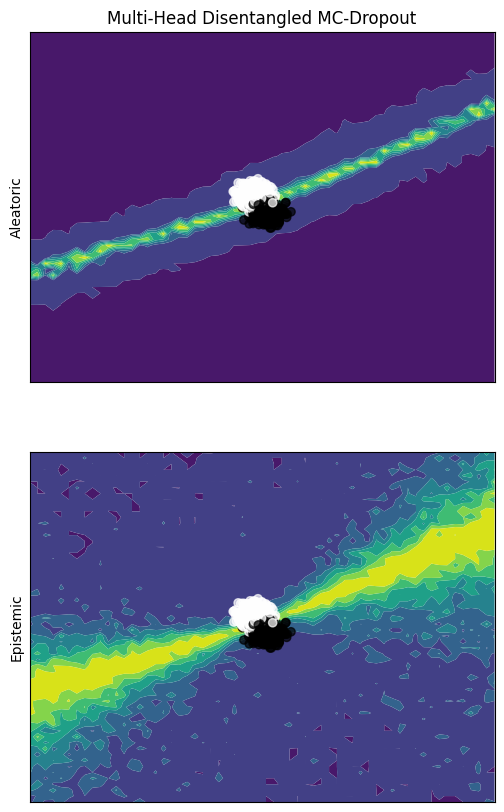

In [6]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
cmap = pl.cm.binary
my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:, 0] = 0.0
my_cmap[:, -1] = 0.7
my_cmap = ListedColormap(my_cmap)


fig, axes =  plt.subplots(ncols=1, nrows=2, figsize=(6, 10), squeeze=False)    
ax_ale = axes[0][0]
ax_epi = axes[1][0]

cf_ale = ax_ale.contourf(xx, yy, ale_entropy, antialiased=True)
ax_ale.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_ale.get_xaxis().set_ticks([])
ax_ale.get_yaxis().set_ticks([])
ax_ale.autoscale(False)

cf_epi = ax_epi.contourf(xx, yy, epi_entropy, antialiased=True)
ax_epi.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_epi.get_xaxis().set_ticks([])
ax_epi.get_yaxis().set_ticks([])
ax_epi.autoscale(False)

ax_ale.set_ylabel("Aleatoric")
ax_epi.set_ylabel("Epistemic")
ax_ale.set_title("Multi-Head Disentangled MC-Dropout")

plt.show()

In [7]:
def evaluate_entropy_dropout_model(entropy_model, samples, num_samples=NUM_SAMPLES):
    preds = entropy_model.predict(samples, num_samples=num_samples)
    print(preds.shape)
    entropy = uncertainty(preds)
    
    return entropy

def train_entropy_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))
    model.add(Dense(2, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    model.fit(x_train, y_train, verbose=2, epochs=50)
    
    mc_model = StochasticClassifier(model)

    return mc_model


In [8]:
entropy_model = train_entropy_dropout_model(X, y)

Epoch 1/50
32/32 - 0s - loss: 0.5316 - accuracy: 0.7130 - 145ms/epoch - 5ms/step
Epoch 2/50
32/32 - 0s - loss: 0.3372 - accuracy: 0.8790 - 17ms/epoch - 543us/step
Epoch 3/50
32/32 - 0s - loss: 0.2545 - accuracy: 0.9220 - 16ms/epoch - 509us/step
Epoch 4/50
32/32 - 0s - loss: 0.2056 - accuracy: 0.9280 - 15ms/epoch - 460us/step
Epoch 5/50
32/32 - 0s - loss: 0.1864 - accuracy: 0.9360 - 14ms/epoch - 438us/step
Epoch 6/50
32/32 - 0s - loss: 0.1957 - accuracy: 0.9410 - 14ms/epoch - 438us/step
Epoch 7/50
32/32 - 0s - loss: 0.1655 - accuracy: 0.9360 - 16ms/epoch - 488us/step
Epoch 8/50
32/32 - 0s - loss: 0.1674 - accuracy: 0.9380 - 14ms/epoch - 432us/step
Epoch 9/50
32/32 - 0s - loss: 0.1758 - accuracy: 0.9370 - 14ms/epoch - 452us/step
Epoch 10/50
32/32 - 0s - loss: 0.1746 - accuracy: 0.9390 - 14ms/epoch - 444us/step
Epoch 11/50
32/32 - 0s - loss: 0.1662 - accuracy: 0.9420 - 14ms/epoch - 441us/step
Epoch 12/50
32/32 - 0s - loss: 0.1620 - accuracy: 0.9400 - 15ms/epoch - 462us/step
Epoch 13/50
32

In [9]:
individual_predictions = entropy_model.predict_samples(domain, num_samples=NUM_SAMPLES)
individual_predictions.shape

(100, 3600, 2)

In [10]:
from keras import activations

# Here we try something new: what if we apply this entropy formulation directly on the logits somehow
# I found this has problems
# The entropy formulation no-longer works, because log of negative is NaN
# I am not able to find an alternative approach to this

entropy_model.model.layers[-1].activation = activations.linear
entropy_model.model.compile(loss="sparse_categorical_crossentropy")
individual_predictions = entropy_model.predict_samples(domain, num_samples=NUM_SAMPLES)
original_individual_predictions = individual_predictions

In [11]:
import keras_uncertainty.backend as K

individual_predictions = K.softmax(K.constant(original_individual_predictions), axis=-1).numpy()

In [14]:
def predictive_entropy(probs, axis=-1, eps=1e-6):
    probs = np.mean(probs, axis=0)
    return -np.sum(probs * np.log(probs + eps), axis=axis)

def expected_entropy(probs, eps=1e-6):
  return -np.mean((probs * np.log(probs + eps)).sum(axis=-1), axis=0)

def mutual_information(probs):
  return predictive_entropy(probs) - shannon_entropy(probs)

def logit_variance(logits):
    return np.var(logits, axis=0).mean(axis=-1)

Text(0.5, 1.0, 'Entropy disentangled MC-Dropout')

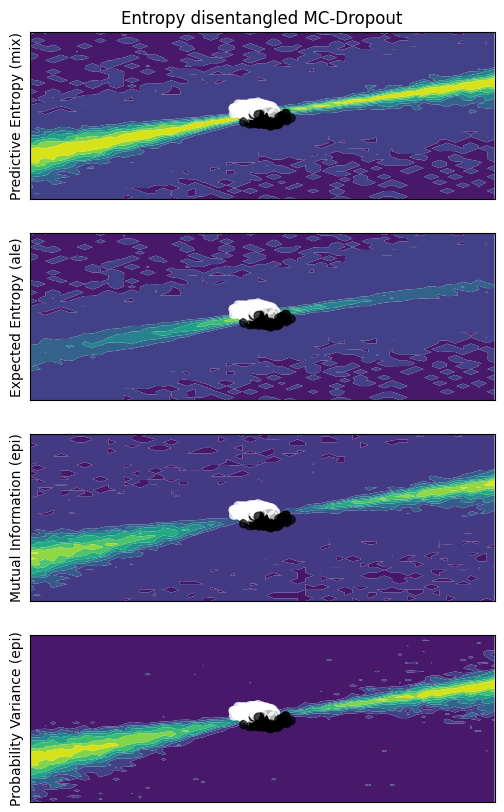

In [15]:
fig, axes =  plt.subplots(ncols=1, nrows=4, figsize=(6, 10), squeeze=False)    
ax_pred = axes[0][0]
ax_exp = axes[1][0]
ax_mi = axes[2][0]
ax_var = axes[3][0]



pred_entr = predictive_entropy(individual_predictions)
pred_entr = pred_entr.reshape(xx.shape)
cf_pred = ax_pred.contourf(xx, yy, pred_entr, antialiased=True)
ax_pred.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_pred.get_xaxis().set_ticks([])
ax_pred.get_yaxis().set_ticks([])
ax_pred.autoscale(False)

exp_entr = expected_entropy(individual_predictions)
exp_entr = exp_entr.reshape(xx.shape)
cf_exp = ax_exp.contourf(xx, yy, exp_entr, antialiased=True)
ax_exp.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_exp.get_xaxis().set_ticks([])
ax_exp.get_yaxis().set_ticks([])
ax_exp.autoscale(False)


mut_inf = mutual_information(individual_predictions)
mut_inf = mut_inf.reshape(xx.shape)
cf_mi = ax_mi.contourf(xx, yy, mut_inf, antialiased=True)
ax_mi.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_mi.get_xaxis().set_ticks([])
ax_mi.get_yaxis().set_ticks([])
ax_mi.autoscale(False)


pred_var = np.std(individual_predictions, axis=0).mean(axis=-1)
pred_var = pred_var.reshape(xx.shape)
cf_var = ax_var.contourf(xx, yy, pred_var, antialiased=True)
ax_var.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_var.get_xaxis().set_ticks([])
ax_var.get_yaxis().set_ticks([])
ax_var.autoscale(False)



ax_pred.set_ylabel("Predictive Entropy (mix)")
ax_exp.set_ylabel("Expected Entropy (ale)")
ax_mi.set_ylabel("Mutual Information (epi)")
ax_var.set_ylabel("Probability Variance (epi)")


ax_pred.set_title("Entropy disentangled MC-Dropout")

In [16]:
np.var(individual_predictions, axis=0).shape

(3600, 2)

In [17]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

disentangling_accuracies = []
disentangling_aleatorics = []
disentangling_epistemics = []

entropy_accuracies = []
entropy_aleatorics = []
entropy_epistemics = []
X_test, y_test = make_blobs(n_samples=500, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
dataset_sizes = np.logspace(start=1, stop=10, base=2, num=20) 

for dataset_size in tqdm(dataset_sizes):

    X_train, y_train = make_blobs(n_samples=int(dataset_size), n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
    
    
    disentangle_model = train_disentangling_dropout_model(X_train, y_train)
    entropy_model = train_entropy_dropout_model(X_train, y_train)

    pred_mean, pred_ale_std, pred_epi_std = disentangle_model.predict(X_test, batch_size=BATCH_SIZE)
    entropy_preds = entropy_model.predict_samples(X_test, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
    disentangling_accuracies.append(accuracy_score(y_test, pred_mean.argmax(axis=1)))
    disentangling_aleatorics.append(uncertainty(pred_ale_std).mean())
    disentangling_epistemics.append(uncertainty(pred_epi_std).mean())

    entropy_accuracies.append(accuracy_score(y_test, entropy_preds.mean(axis=0).argmax(axis=1)))
    entropy_aleatorics.append(expected_entropy(entropy_preds).mean())
    entropy_epistemics.append(mutual_information(entropy_preds).mean())


  0%|                                                                                                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

Epoch 1/50
1/1 - 0s - loss: 1.2828 - accuracy: 0.5000 - 359ms/epoch - 359ms/step
Epoch 2/50
1/1 - 0s - loss: 0.5121 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6963 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5170 - accuracy: 1.0000 - 1ms/epoch - 1ms/step
Epoch 5/50
1/1 - 0s - loss: 1.7917 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 1.6247 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5675 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4603 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6515 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.4164 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6256 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5559 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.8424 - accuracy: 0.5000 - 2ms/epoch - 

  0%|                                                                                                                                                                                                                                                                                            | 0/20 [00:43<?, ?it/s]


NameError: name 'accuracy_score' is not defined

In [ ]:
dataset_size

In [ ]:

dataset_sizes = np.logspace(start=1, stop=10, base=2, num=20) 

plt.plot(dataset_sizes, disentangling_accuracies, label="Disentangling model")
plt.plot(dataset_sizes, entropy_accuracies, label="Entropy model")
plt.ylabel("Accuracy")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


In [ ]:

plt.plot(dataset_sizes, disentangling_aleatorics, label="Disentangling model")
plt.plot(dataset_sizes, entropy_aleatorics, label="Entropy model")
plt.ylabel("Aleatoric uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


In [ ]:

plt.plot(dataset_sizes, disentangling_epistemics / max(disentangling_epistemics), label="Disentangling model (normalised)")
plt.plot(dataset_sizes, entropy_epistemics / max(entropy_epistemics), label="Entropy model (normalised)")
plt.ylabel("Epistemic uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


In [ ]:

# plt.plot(dataset_sizes, disentangling_epistemics, label="Disentangling model")
plt.plot(dataset_sizes, entropy_epistemics, label="Entropy model")
plt.ylabel("Epistemic uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()

In [ ]:
plt.plot(dataset_sizes, disentangling_aleatorics, label="Aleatoric")
plt.plot(dataset_sizes, disentangling_epistemics, label="Epistemic")
plt.title("Multi-head disentangled uncertainties vs. dataset size")
plt.legend()
plt.ylabel("Uncertainty")
plt.xlabel("Dataset size")


In [ ]:
plt.plot(dataset_sizes, (entropy_aleatorics - min(entropy_aleatorics)) / max(entropy_aleatorics - min(entropy_aleatorics)), label="Aleatoric")
plt.plot(dataset_sizes, (entropy_epistemics - min(entropy_epistemics)) / max(entropy_epistemics -min(entropy_epistemics) ), label="Epistemic")
plt.title("Entropy disentangled uncertainties vs. dataset size")
plt.legend()
plt.ylabel("Uncertainty (normalised)")
plt.xlabel("Dataset size")
